# Model Training

In [1]:
!pip install polars

In [2]:
import polars as pl
train_df_click = pl.read_parquet('../input/comp9417-preprocessing-and-test-data/train_df_click.parquet')
train_df_cart = pl.read_parquet('../input/comp9417-preprocessing-and-test-data/train_df_cart.parquet')
train_df_order = pl.read_parquet('../input/comp9417-preprocessing-and-test-data/train_df_order.parquet')

In [3]:
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit

train_click = train_df_click.to_pandas()
train_cart = train_df_cart.to_pandas()
train_order = train_df_order.to_pandas()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
import pickle

def save_model(name, model):
    f = f'/kaggle/working/{name}.pkl' 

    with open(f, 'wb') as file:  
        pickle.dump(model, file)

In [5]:
import lightgbm
import matplotlib.pyplot as plt

# LightGBM
def train_LGBM(data, event_type):
    X_train = data.iloc[:,:-1]
    y_train = data.iloc[:, -1]
    
    groups_train = X_train.groupby('session').size().to_frame('size')['size'].to_numpy()
    
    model = lightgbm.LGBMRanker(
        objective="lambdarank",
        boosting_type = "gbdt",
        n_estimators = 5,
        metric= "ndcg",
        num_leaves = 10,
        learning_rate = 0.05,
        max_depth = -1
    )
    
    model.fit(
        X=X_train,
        y=y_train,
        group=groups_train
    )
    
    save_model(f'lgbm_{event_type}', model)
    
    return model

In [6]:
import optuna

def train_LGBM_x(data, event_type):
    def objective(trial):
        X_train = data.iloc[:,:-1]
        y_train = data.iloc[:, -1]

        groups_train = X_train.groupby('session').size().to_frame('size')['size'].to_numpy()

        params = {
            "objective": "lambdarank",
            "boosting_type": "gbdt",
            "metric": "ndcg",
            "num_leaves": trial.suggest_int("num_leaves", 2, 256),
            "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1),
            "max_depth": trial.suggest_int("max_depth", -1, 10)
        }

        
        gbm = lgb.train(param, dtrain)
        preds = gbm.predict(valid_x)
        pred_labels = np.rint(preds)
        accuracy = sklearn.metrics.accuracy_score(valid_y, pred_labels)
        return accuracy
    
    tune = optuna.create_study(direction="maximize")
    tune.optimize(objective, n_trials=100)

In [7]:
train_list = [[train_click, 'click'], [train_cart, 'cart'], [train_order, 'order']]
models = []
for tr in train_list:
    models.append(train_LGBM(tr[0], tr[1]))
#     models.append(train_LGBM_x(tr[0], tr[1]))

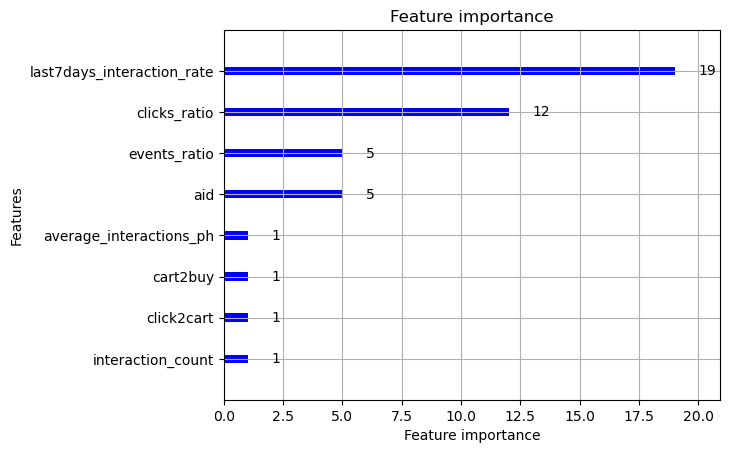

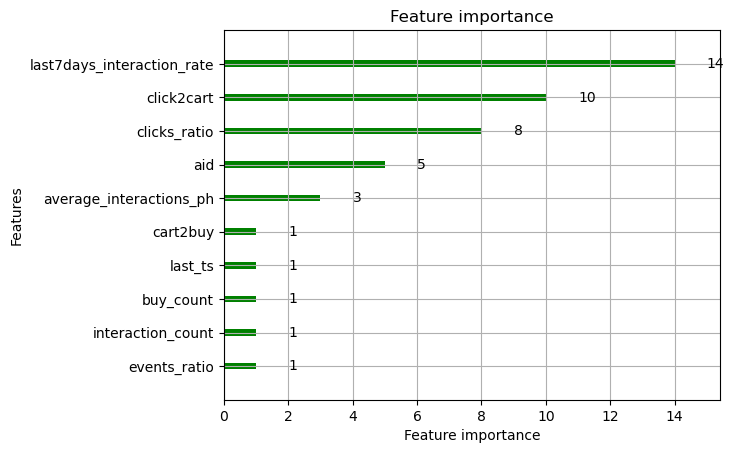

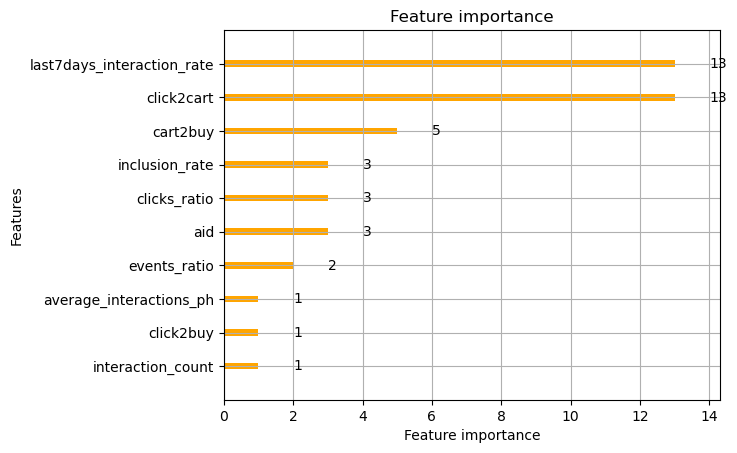

In [8]:
colors = ['blue', 'green', 'orange']
for idx, model in enumerate(models):
    lightgbm.plot_importance(model, color=colors[idx], importance_type='split')
#     plt.savefig(f'feature_{event_type}.png')

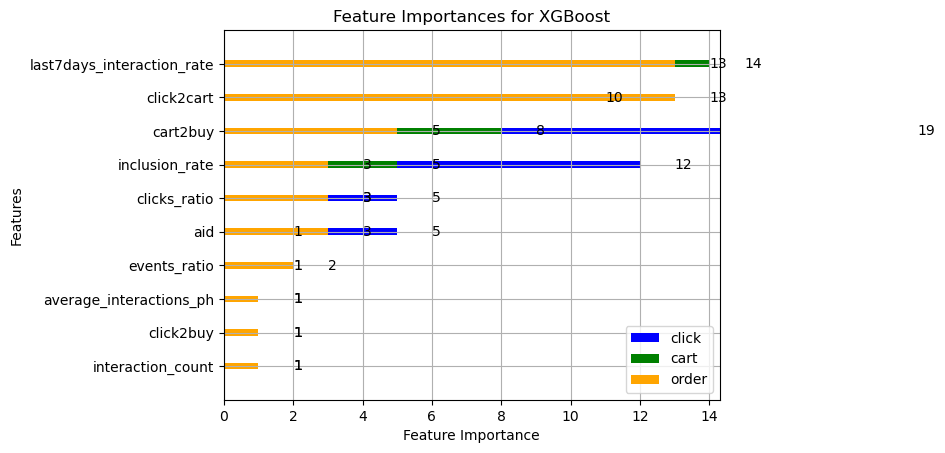

In [9]:
feature_names = list(train_click.columns.values)[:-1]
fig, ax = plt.subplots()
colors = ['blue', 'green', 'orange']

for idx, model in enumerate(models):
    lightgbm.plot_importance(model, importance_type='split', ax=ax, color=colors[idx], label=train_list[idx][1])

ax.legend()

ax.set_xlabel('Feature Importance')
ax.set_ylabel('Features')
plt.title('Feature Importances for XGBoost')

# Show the plot
plt.show()